# Check GAM modeling results

In [1]:
%load_ext autoreload
%autoreload 2
%cd D:\netmob25

D:\netmob25


In [19]:
# Load libs
import pandas as pd
import numpy as np
from pprint import pprint
import pyperclip
from lib import helpers as helpers
from interpret.glassbox import ExplainableBoostingRegressor
import shap
import pickle

In [20]:
var_cat = ['time_threshold', 'amenity', 'mode', 'Gender', 'Education', 'Household_type', 
            'Car_no', 'Bike_no', 'Two_wheeler_no', 'Escooter_no', 'pt_sub']
var_con = ['d2h_nh', 'Age']
# Load data for modelling
print('Load data.')
df = pd.read_parquet("results/activity_access_ind_model.parquet")
df['log_disparity'] = np.log(df['gap'])

# Step 4: Combine into final feature list
features = var_con + var_cat
pyperclip.copy('\n'.join(features))
print(', '.join(features))

Load data.
d2h_nh, Age, time_threshold, amenity, mode, Gender, Education, Household_type, Car_no, Bike_no, Two_wheeler_no, Escooter_no, pt_sub


## 1. Check the model results

In [30]:
perf_dict_list = []
md = 'all'
path2result = 'results/ebm/'
gam_results = helpers.EBMResultsOrganizer(file_loc=path2result + f'model_{md}.p')
gam_results.load_raw_data(select='all')

# Feature performance
perf = gam_results.performance()
perf['model'] = md
print(perf)


Load data.
{'rmse_train': 0.9704016728890006, 'r2_train': 0.44363670118838927, 'rmse_test': 1.0064021282692124, 'r2_test': 0.36221855198507835, 'model': 'all'}


In [31]:
# Feature importance
df_f = gam_results.feature_importance()
df_f.to_csv(f'results/ebm/f_score.csv', index=False)
print(len(df_f[df_f['Score'] > 0.01]))
df_f

11


,Name,Color,Score
2,Access (home),steelblue,0.485877
11,Distance to Home Neighborhood & Access (home),black,0.217118
0,Distance to Home Neighborhood,steelblue,0.188643
10,Public Transport Subscription,steelblue,0.163667
6,Car number,steelblue,0.100062
5,Household type,coral,0.067338
1,Age,coral,0.063340
12,Distance to Home Neighborhood & Car number,black,0.056084
4,Education,coral,0.049187
7,Bike number,steelblue,0.036569


In [32]:
# Load feature effects
gam_results.feature_scores()
df_fscore_f = gam_results.single_feature_effect()
df_fscore_f.to_csv(f'results/ebm/features.csv', index=False)

In [34]:
interaction_path = f'D:/netmob25/results/ebm/interactions/'
gam_results.interection_effect(path2save=interaction_path)

D:\netmob25\lib\helpers.py:184: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.          0.          0.         ... 35.47388251 35.47388251
 35.47388251]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  # Get the frequency of the interaction cells
D:\netmob25\lib\helpers.py:185: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1.     1.5    2.25 ... 505.   626.5  783.  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  if var1 not in labels_cat:
D:\netmob25\lib\helpers.py:184: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.      

IndexError: list index out of range

In [ ]:
interaction_data = []

for key, value in gam_results.all_fscore["interaction"].items():
    feature1, feature2 = key.split(" & ")
    x_edges = np.array(value[0])  # either edges or categorical labels
    y_edges = np.array(value[1])
    effect_matrix = np.array(value[2])

    # Determine dimensionality
    is_x_categorical = not np.issubdtype(x_edges.dtype, np.number)
    is_y_categorical = not np.issubdtype(y_edges.dtype, np.number)

    # Compute x-axis values
    if is_x_categorical:
        x_vals = x_edges
    else:
        x_vals = (x_edges[:-1] + x_edges[1:]) / 2

    # Compute y-axis values
    if is_y_categorical:
        y_vals = y_edges
    else:
        y_vals = (y_edges[:-1] + y_edges[1:]) / 2

    for i, y in enumerate(y_vals):
        for j, x in enumerate(x_vals):
            # Adjust indexing based on layout
            effect = effect_matrix[i, j] if effect_matrix.shape == (len(y_vals), len(x_vals)) else effect_matrix[j, i]
            interaction_data.append({
                "feature1": feature1,
                "feature2": feature2,
                "x": x,
                "y": y,
                "effect": effect
            })

df_interactions = pd.DataFrame(interaction_data)

In [58]:
df_interactions.to_csv("results/ebm/interactions.csv", index=False)

## 2. Shap values

In [26]:
# explain the GAM model with SHAP
with open("results/ebm/model_all_explained.p", "rb") as f:
    shap_result = pickle.load(f)

In [27]:
shap_result.feature_names

['d2h_nh',
 'Age',
 'time_threshold_30 min',
 'amenity_Essential needs',
 'amenity_Health services',
 'amenity_Social & Leisure',
 'mode_Public transit',
 'Gender_Woman',
 'Education_1.0',
 'Education_2.0',
 'Education_3.0',
 'Education_4.0',
 'Education_5.0',
 'Education_9.0',
 'Household_type_1',
 'Household_type_2',
 'Household_type_3',
 'Household_type_4',
 'Household_type_5',
 'Household_type_6',
 'Household_type_7',
 'Car_no_1',
 'Car_no_2',
 'Car_no_3',
 'Car_no_4',
 'Car_no_5',
 'Car_no_8',
 'Bike_no_1',
 'Bike_no_2',
 'Bike_no_3',
 'Bike_no_4+',
 'Two_wheeler_no_1',
 'Two_wheeler_no_2',
 'Two_wheeler_no_3',
 'Two_wheeler_no_4+',
 'Escooter_no_1',
 'Escooter_no_2',
 'Escooter_no_3',
 'Escooter_no_4+',
 'pt_sub_True']

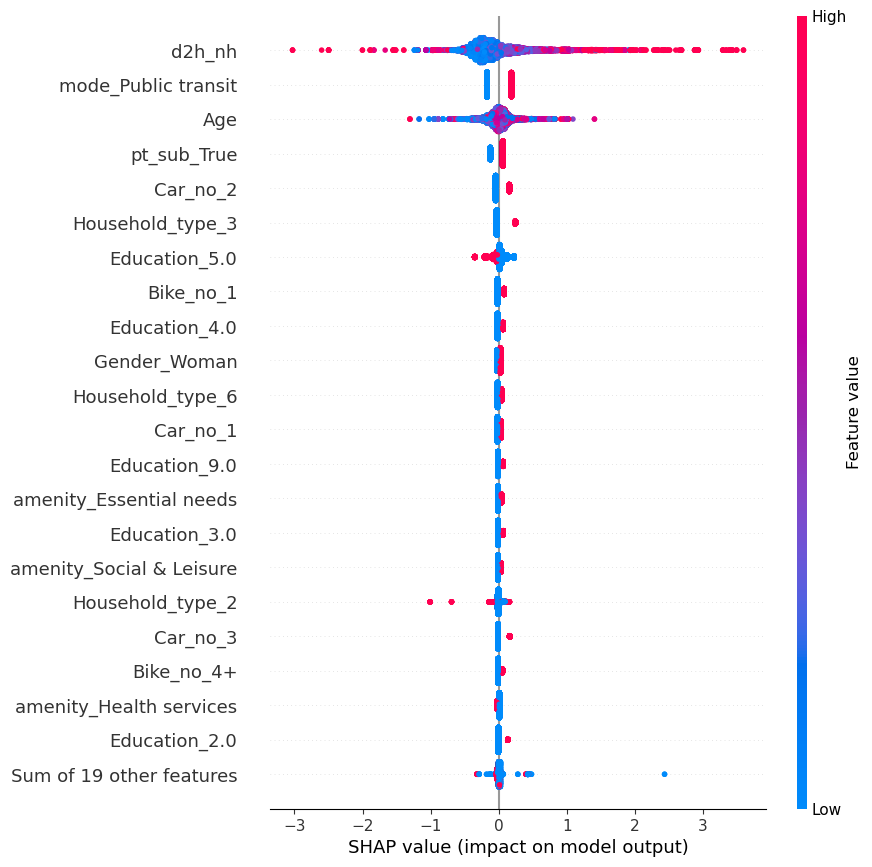

In [29]:
# Example: manually reconstruct SHAP Explanation
shap_values = shap_result.values if hasattr(shap_result, 'values') else shap_result
X = shap_result.data if hasattr(shap_result, 'data') else None

explanation = shap.Explanation(values=shap_values, data=X, feature_names=shap_result.feature_names)
shap.plots.beeswarm(explanation, max_display=22)